<a href="https://colab.research.google.com/github/yvkrishna/paddy_disease_classification/blob/master/Paddy_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!git clone https://github.com/yvkrishna/paddy_disease_classification.git

Cloning into 'paddy_disease_classification'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (534/534), done.
remote: Compressing objects: 100% (514/514), done.
remote: Total 534 (delta 31), reused 516 (delta 20), pack-reused 0
Receiving objects: 100% (534/534), 37.82 MiB | 34.70 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os 
from os import path
from PIL import Image

In [96]:
# importing all tensorflow modules 
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

In [89]:
os.chdir('/content')

Numpy is used to manipulating and using arrays of data easily.

Pandas helps us to play with the data .

Matplotlib is used to visulaize the data.

In [90]:
os.chdir('paddy_disease_classification/rice_leaf_diseases')
path = os.getcwd()
training_classes = [f.name for f in os.scandir(path) if f.is_dir()]
print(training_classes)

['Leaf smut', 'Bacterial leaf blight', 'Brown spot']


Image Pre Processing Steps

In [91]:
def applyMedian(folder):
  ''' 
    Applies Meadian Filter to all the images in the given folder. 
    Args : 
      # img_loc: (str). : Image_dir in the current class.
      # img_save: (str). : Image_dir to save the images
      Folder : (str). : Image_directory
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()

  for image in list(os.listdir(current_path)):
    img = cv2.imread(image)
    # applies median filter to the image.
    median = cv2.medianBlur(img, 5)
    # saving the image by adding the blur feature.
    im = Image.fromarray(median)
    im.save(image)
  os.chdir(previous_path)

In [93]:
for folder in training_classes:
  applyMedian(folder)

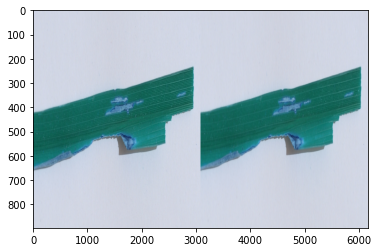

In [ ]:
# Deeninin reference ga ikkade unchu. Dont change the code
img = cv2.imread('leaf.JPG')
median = cv2.medianBlur(img, 5)
compare = np.concatenate((img, median), axis=1) #side by side comparison
plt.imshow(compare,aspect='auto')

In [99]:
# Goutham ikkadi nunchi nuvvu work start cheyye.
# Works like data augumentation ikkada choodu.
# Later We will use this data to train a pre trained model.

In [100]:
# For Now single pre processing step is completed. If mam tells to add any more,
# I will add those features.

In [97]:
# Pre trained model 
pre_trained_model = InceptionResNetV2(include_top=True, weights='imagenet', pooling=None)

225214464/225209952 [==============================] - 2s 0us/step
